In [140]:
import pickle
import pathlib

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

Obtendo os dados e processando categóricas.

In [141]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
print(DATA_DIR)
clean_data_path = DATA_DIR / 'processed' / 'ames_clean.pkl'
with open(clean_data_path, 'rb') as file:
    data = pickle.load(file)

c:\Users\Pedro Antônio Silva\Desktop\Semestre 4\Machine Learning\proj_1\ames\data


In [142]:
model_data = data.copy()

Funções para análise de dados

In [143]:
def nonNull_percent(label, null_value = 0 ):
    f = model_data[label] != null_value
    return (model_data[label][f].value_counts().sum()/model_data[label].shape[0] *100)

def heatMapCorr(labels):
    correlation_matrix = model_data[labels + ["SalePrice"]].corr()

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
    plt.title('Correlation Heatmap')
    plt.show()

Copia do processamento feito no notebook 03

In [144]:
model_data = data.copy()
categorical_columns = []
ordinal_columns = []
for col in model_data.select_dtypes('category').columns:
    if model_data[col].cat.ordered:
        ordinal_columns.append(col)
    else:
        categorical_columns.append(col)
for col in ordinal_columns:
    codes, _ = pd.factorize(data[col], sort=True)
    model_data[col] = codes
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data, drop_first=True)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()
model_data = pd.get_dummies(model_data, drop_first=True)
model_data.info()
for cat in categorical_columns:
    dummies = []
    for col in model_data.columns:
        if col.startswith(cat + "_"):
            dummies.append(f'"{col}"')
    dummies_str = ', '.join(dummies)
    print(f'From column "{cat}" we made {dummies_str}\n')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2877 entries, 0 to 2929
Columns: 166 entries, Lot.Frontage to Exterior_Other
dtypes: bool(2), float64(34), int64(12), uint8(118)
memory usage: 1.4 MB
From column "MS.SubClass" we made "MS.SubClass_30", "MS.SubClass_50", "MS.SubClass_60", "MS.SubClass_70", "MS.SubClass_80", "MS.SubClass_85", "MS.SubClass_90", "MS.SubClass_120", "MS.SubClass_160", "MS.SubClass_190", "MS.SubClass_Other"

From column "MS.Zoning" we made "MS.Zoning_RH", "MS.Zoning_RL", "MS.Zoning_RM"

From column "Land.Contour" we made "Land.Contour_HLS", "Land.Contour_Low", "Land.Contour_Lvl"

From column "Lot.Config" we made "Lot.Config_CulDSac", "Lot.Config_FR2", "Lot.Config_FR3", "Lot.Config_Inside"

From column "Neighborhood" we made "Neighborhood_BrDale", "Neighborhood_BrkSide", "Neighborhood_ClearCr", "Neighborhood_CollgCr", "Neighborhood_Crawfor", "Neighborhood_Edwards", "Neighborhood_Gilbert", "Neighborhood_IDOTRR", "Neighborhood_MeadowV", "Neighborhood_Mitchel", "N

Feature Engineering

Abrindo dados como histogramas para checar distribuição.

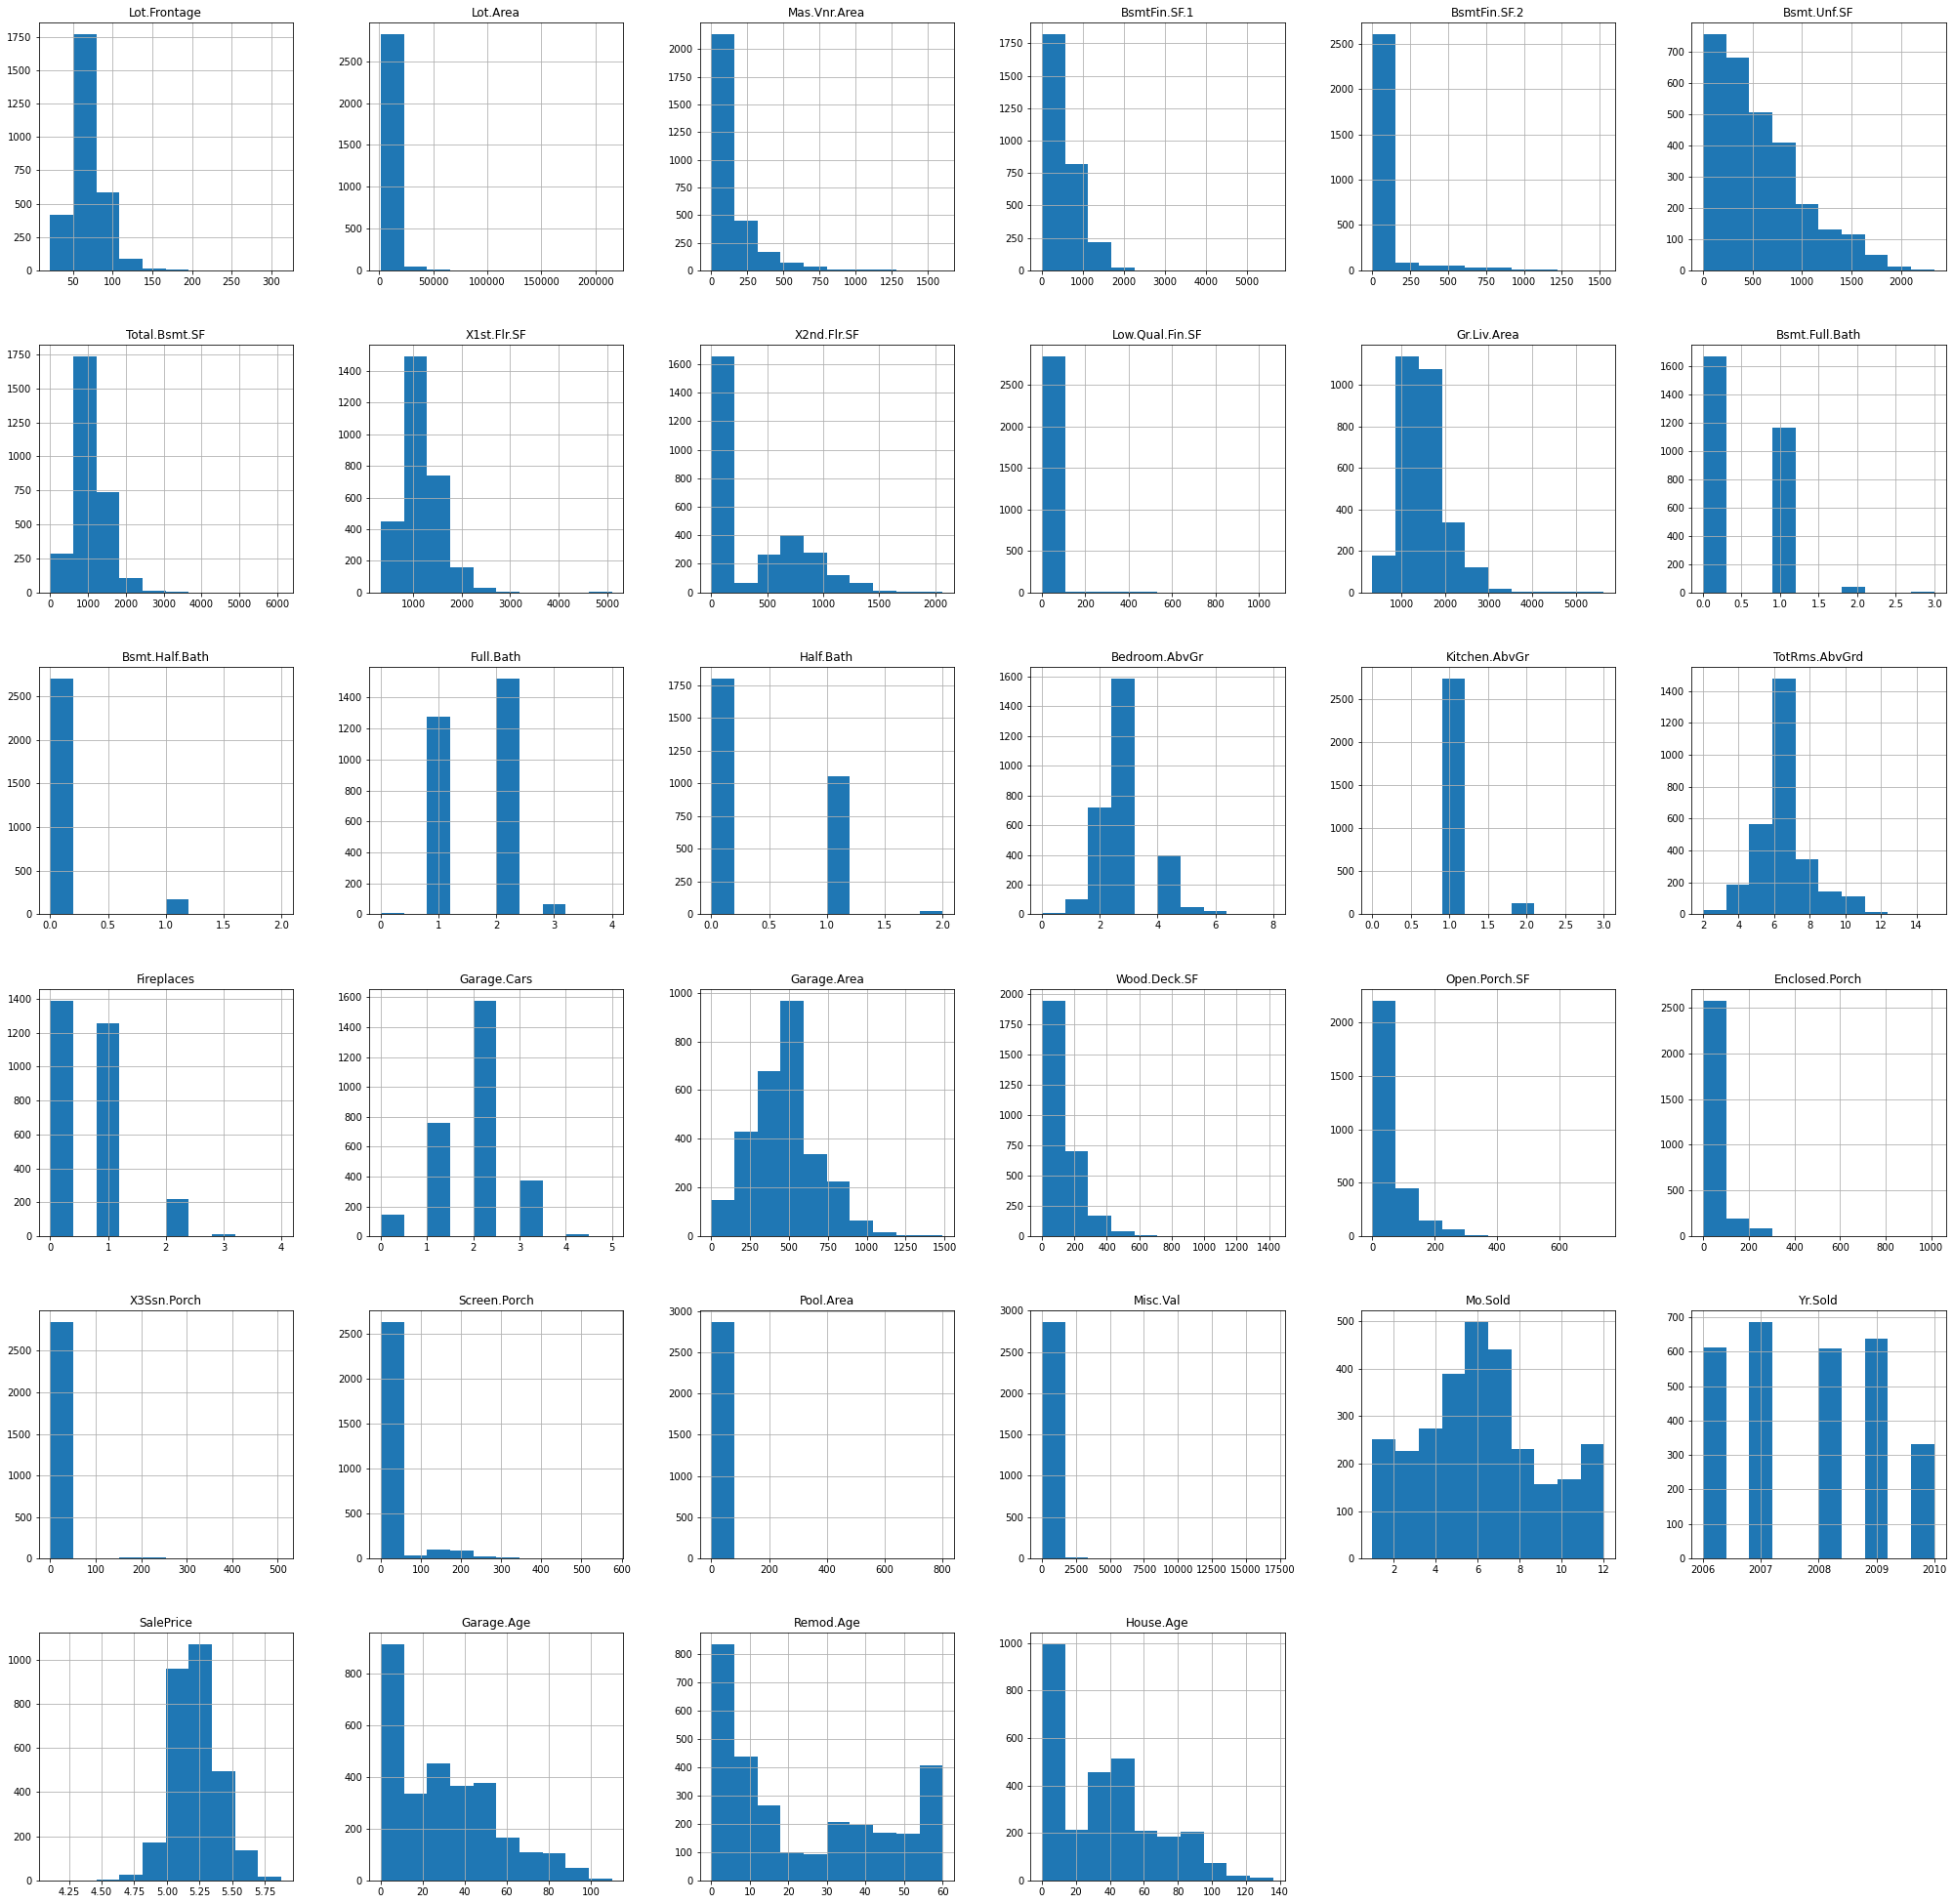

In [145]:
data.hist(figsize=(35,35))
print()

Primeiro, checarei variáveis relacionadas ao Lote da casa

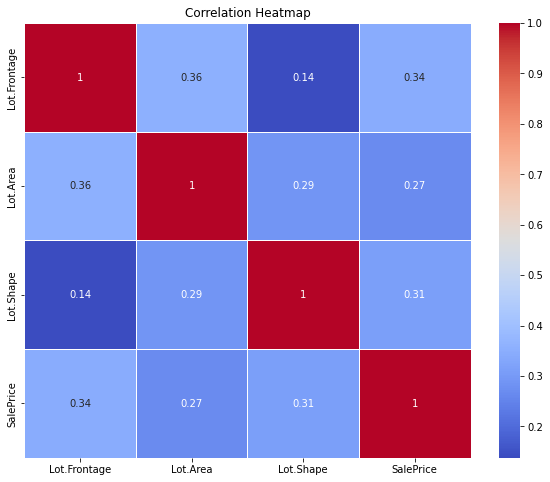

In [146]:
lot_cat = ["Lot.Frontage","Lot.Area","Lot.Shape"]
heatMapCorr(lot_cat)

Todas aparentam ter boa correlação individual com o target, então vamos analisar suas distribuições em busca de melhor representar nossos dados.

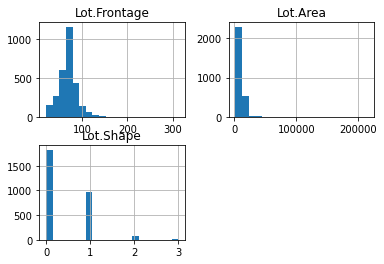

In [147]:
model_data[lot_cat].hist(bins=20)
print()

Pelo formato do gráfico, podemos perceber que os dados de "Lot.Area" tem uma grande quantidade de dados proximos ao zero e conforme a area cresce, a concentração de dados diminui - aplicar uma transformação para log fará nossos dados se tornarem mais legíveis e menos exparsos, mantendo sua propriedade e relevância.

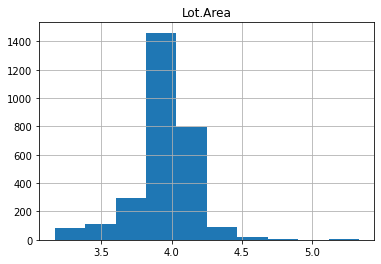

In [148]:
# seems like lot area might use some logs
pd.DataFrame(np.log10(data["Lot.Area"])).hist()
print()

OBS: Daqui para frente, dados com esse formato serão armazenados para serem transformados de uma vez só.

0.446062177443733
40.25026068821689


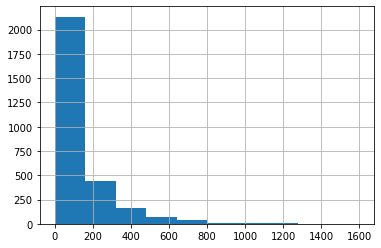

In [149]:
print(model_data[["Mas.Vnr.Area","SalePrice"]].corr()["SalePrice"][0]) # high correlation...
model_data["Mas.Vnr.Area"].hist()
print(nonNull_percent("Mas.Vnr.Area")) # has a good non-null amount...
right_skewed = ["Mas.Vnr.Area"]

In [150]:
# data["Mas.Vnr.Area"] = np.log1p(data["Mas.Vnr.Area"])
# data["Mas.Vnr.Area"].hist(bins=20)

Analysing Exter attributes

Essas features delimitam uma avaliação/ordem crescente e avaliam dados da mesma área, então criar uma feature generalizada pode nos ajudar a remover redundancia dos dados.

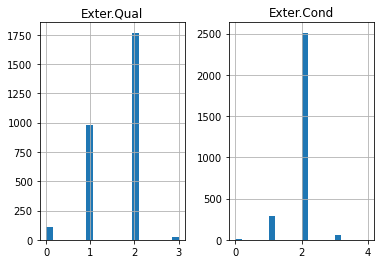

In [151]:
# External features
exter_cat = ["Exter.Qual","Exter.Cond"]
model_data[exter_cat].hist(bins=20) # these seem to reflect a more umbalanced rating
print()

Além disso, podemos verificar atráves dos histogramas que a feature criada tem comportamento similar ao de seus componentes e melhora a distribuição dos dados.

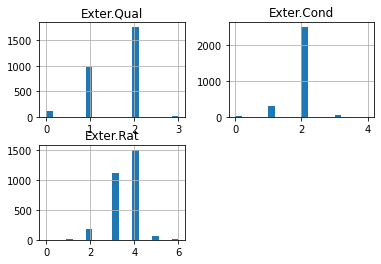

In [152]:
model_data["Exter.Rat"] = model_data["Exter.Qual"] + model_data["Exter.Cond"]
model_data[exter_cat+["Exter.Rat"]].hist(bins=20)
model_data = model_data.drop(columns=exter_cat)

Dados de Área do Porão

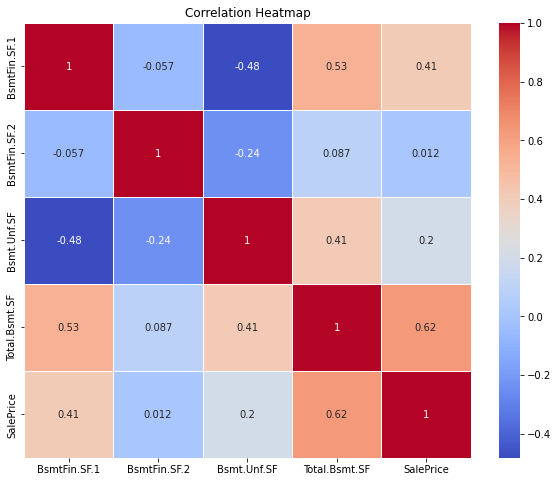

In [153]:
# Basement Features (Area)
basement_cat = ["BsmtFin.SF.1","BsmtFin.SF.2", "Bsmt.Unf.SF","Total.Bsmt.SF"]
heatMapCorr(basement_cat) # checking relevance...

BsmtFin.SF.1 68.57838025721237
BsmtFin.SF.2 12.02641640597845
Bsmt.Unf.SF 91.83176920403197
Total.Bsmt.SF 97.46263468891206


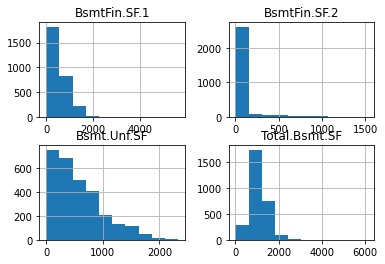

In [154]:
model_data[basement_cat].hist()
for cat in basement_cat:
    print(cat, nonNull_percent(cat))
    
right_skewed += ["BsmtFin.SF.1","BsmtFin.SF.2", "Bsmt.Unf.SF"]

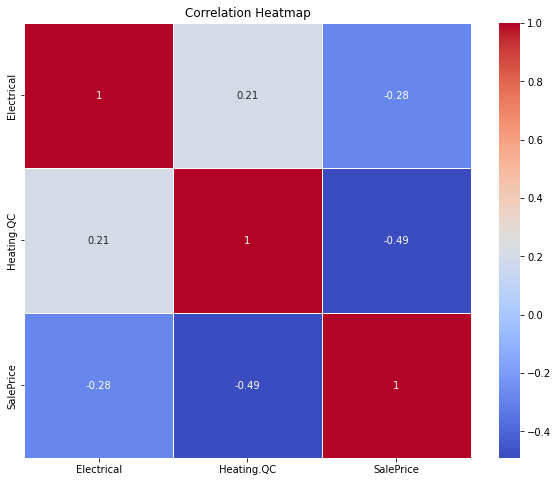

8.168230795968022
48.348974626346894


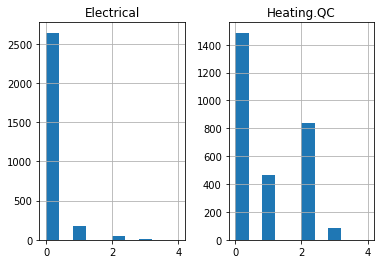

In [155]:
# Heating and Eletrical categories
he_cat = ["Electrical","Heating.QC"]
heatMapCorr(he_cat)  # seems relevant enough
model_data[he_cat].hist()
print(nonNull_percent(he_cat[0]))
print(nonNull_percent(he_cat[1]))

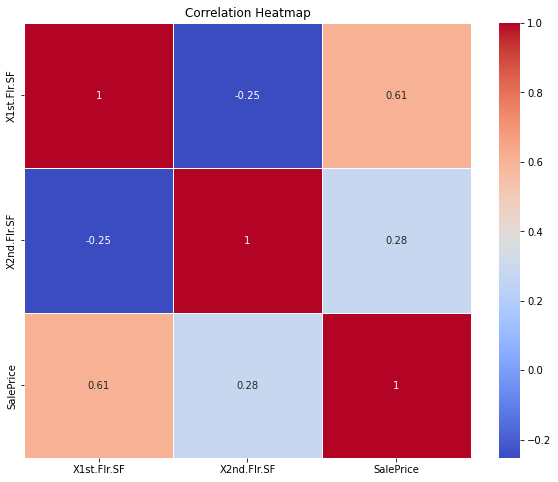

100.0
42.75286757038582


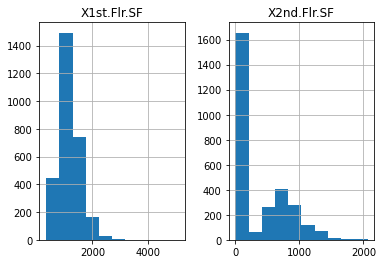

In [156]:
# xcat features
xcat = ["X1st.Flr.SF","X2nd.Flr.SF"] 
heatMapCorr(xcat)
model_data[xcat].hist()
print(nonNull_percent(xcat[0]))
print(nonNull_percent(xcat[1]))
# No worries it seems, still, what is it?
right_skewed.append(xcat[1])

In [157]:
model_data[["Low.Qual.Fin.SF","SalePrice"]].corr()["SalePrice"][0]
nonNull_percent("Low.Qual.Fin.SF")

1.3555787278415017

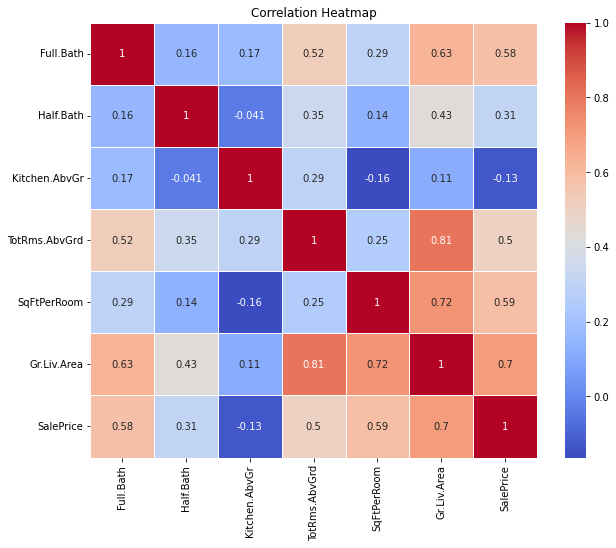

array([[<AxesSubplot:title={'center':'Full.Bath'}>,
        <AxesSubplot:title={'center':'Half.Bath'}>],
       [<AxesSubplot:title={'center':'Kitchen.AbvGr'}>,
        <AxesSubplot:title={'center':'TotRms.AbvGrd'}>],
       [<AxesSubplot:title={'center':'SqFtPerRoom'}>,
        <AxesSubplot:title={'center':'Gr.Liv.Area'}>]], dtype=object)

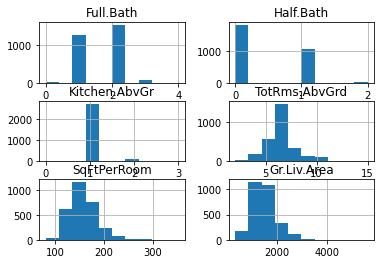

In [158]:
rooms = ["Full.Bath","Half.Bath", "Kitchen.AbvGr", "TotRms.AbvGrd"]
model_data["SqFtPerRoom"] =  model_data["Gr.Liv.Area"] / (model_data["TotRms.AbvGrd"] +
                                                       model_data["Full.Bath"] +
                                                       model_data["Half.Bath"] +
                                                       model_data["Kitchen.AbvGr"])
heatMapCorr(rooms+["SqFtPerRoom","Gr.Liv.Area"])
model_data[rooms + ["SqFtPerRoom","Gr.Liv.Area"]].hist()

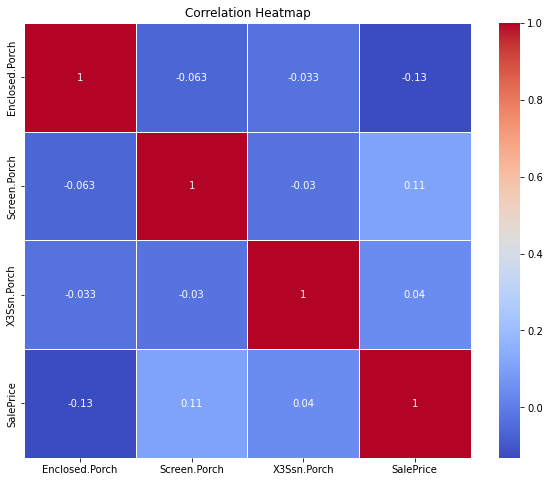

15.363225582203684
8.86339937434828
1.251303441084463


In [159]:
# Porch Features
porch_cat = ["Enclosed.Porch", "Screen.Porch", "X3Ssn.Porch"]
heatMapCorr(porch_cat) # low relevance for everyone


for cat in porch_cat:
    print(nonNull_percent(cat))

In [160]:
model_data = model_data.drop(columns=["Pool.Area","Misc.Val"])

array([[<AxesSubplot:title={'center':'Mas.Vnr.Area'}>,
        <AxesSubplot:title={'center':'BsmtFin.SF.1'}>],
       [<AxesSubplot:title={'center':'BsmtFin.SF.2'}>,
        <AxesSubplot:title={'center':'Bsmt.Unf.SF'}>],
       [<AxesSubplot:title={'center':'X2nd.Flr.SF'}>, <AxesSubplot:>]],
      dtype=object)

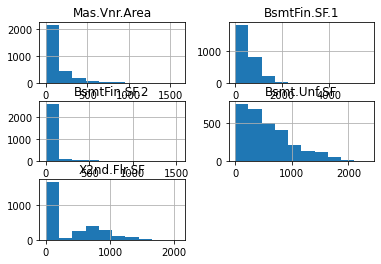

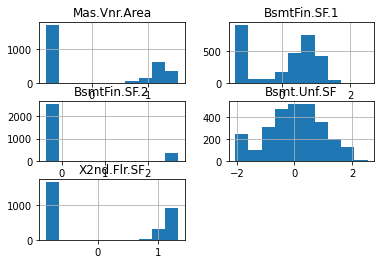

In [161]:
from sklearn.preprocessing import PowerTransformer

model_data[right_skewed].hist()
p = PowerTransformer()
model_data[right_skewed] = p.fit_transform(model_data[right_skewed])
model_data[right_skewed].hist()

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

y = model_data["SalePrice"].copy()
X = model_data.drop(columns=["SalePrice"]).copy()
        
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.25,random_state=12,)

piped_model = Pipeline([
    ("Scaler", StandardScaler()),
    ("Ridge", Ridge())
])

param_grid_r = {
    'Ridge__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
}

grid_search_r = GridSearchCV(piped_model, param_grid_r, 
                              cv=5, scoring="neg_mean_squared_error")

grid_search_r.fit(Xtrain,ytrain)


In [ ]:
grid_search_r.best_params_

In [ ]:
score = cross_val_score(grid_search_r.best_estimator_,Xtrain,ytrain, scoring="neg_mean_squared_error")
score = np.sqrt(-score)
score

In [ ]:
error_percent = 100 * (10**score - 1)
error_percent